Osnabrück University - Computer Vision (Winter Term 2016/17) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack

# Exercise Sheet 04: Basic Operations - Segmentation¶

## Introduction

This week's sheet should be solved and handed in before the end of **Sunday, December 4, 2016**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (the exponential function) [0 Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What is an *exponential function*? How can it be characterized? What is special about $e^x$?

Exponential function is a taking a number to the power of another number n - multiplying it times itself n times. 

**b)** How is the exponential function defined for complex arguments? In what way(s) does this generalize the real case?

**c)** The complex exponential function allows to define a mapping $\mathbb{R}\to\mathbb{C}$ by $x\mapsto e^{ix}$? How does the graph of this mapping look like? Where are the points $e^{2\pi i\frac mn}$ for $m=0,...,n\in\mathbb{N}$ located on this graph?

## Assignment 1: Histogram-based segmentation [6 Points]

### a) Histogram-based segmentation

What is histogram-based segmentation? What are it's goals, benefits, and problems?

Histogram-based segmentation tries to segment a given image into meaningful segments using the histogram of the image. It tries to find the right treshold to separate parts of the image. A simple example would be the segmentation of the image into the foreground and the background based on the given gray values.

### b) Threshold computation

There exist different methods to automatically determine a threshold for an image. Find at least two that are provided by scipy and describe them in more detail. Then apply them to the images `schrift.png` and `pebbles.jpg`.

Example 1: Otsu's method: Otsu’s method calculates an “optimal” threshold by maximizing the variance between two classes of pixels, which are separated by the threshold. (Equivalently, this threshold minimizes the intra-class variance.)
Example 2: adaptive treshold: Here, we binarize an image using the threshold_adaptive function, which calculates thresholds in regions of size block_size surrounding each pixel (i.e. local neighborhoods). Each threshold value is the weighted mean of the local neighborhood minus an offset value.
Other tresholding options include: Yen, Minimum, Triangle, Li, Isodata and Mean. (source http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_thresholding.html)

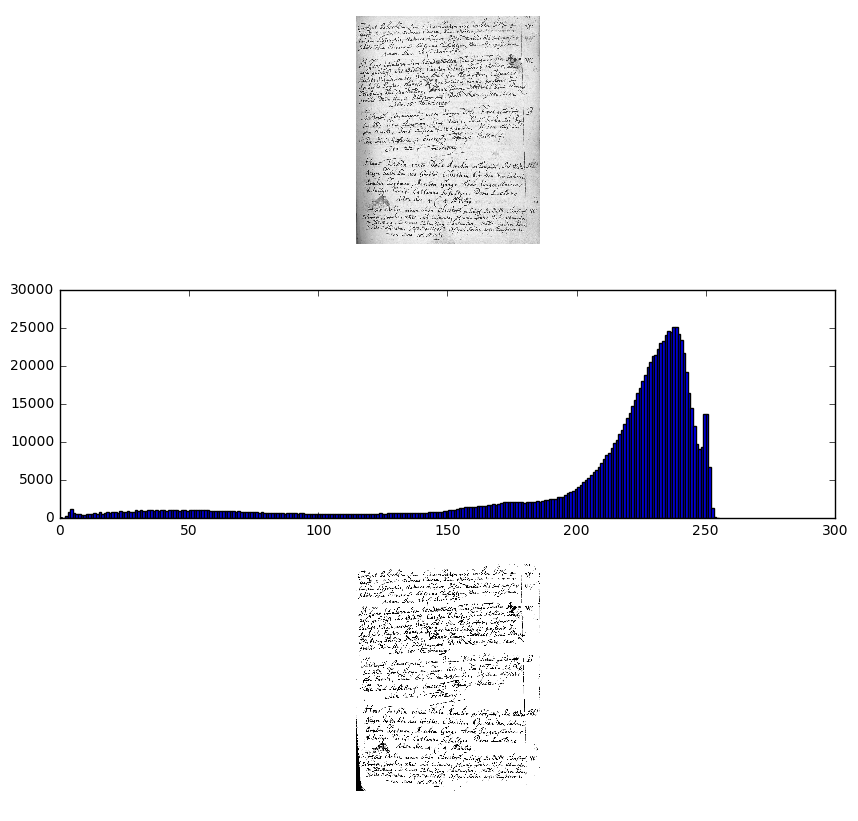

In [1]:
from scipy import misc
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

img = misc.imread('schrift.png', mode = 'L') # 'schrift.png' or 'pebbles.jpg'

segments = img

thresh = threshold_otsu(img)
binary = img > thresh
segments = binary

plt.figure(figsize=(10, 10))
plt.gray()
plt.subplot(3,1,1); plt.axis('off'); plt.imshow(img)
plt.subplot(3,1,2); plt.hist(img.flatten(),256,(0,255))
plt.subplot(3,1,3); plt.axis('off'); plt.imshow(segments)
plt.show()

### c) Shading

Shading may cause a problem to histogram based segmentation. In the lecture (CV-07 slide 13), it was proposed to compute a shading image to deal with that problem. Apply this approach to the images `schrift.png` and `pebbles.jpg`.


[[164 164 164 ..., 189 189 185]
 [164 164 164 ..., 189 189 186]
 [165 165 166 ..., 189 187 183]
 [166 166 166 ..., 187 183 182]
 [167 167 167 ..., 187 183 181]]
[[ 0.00609756  0.00609756  0.00609756 ...,  0.00529101  0.00529101
   0.00540541]
 [ 0.00609756  0.00609756  0.00609756 ...,  0.00529101  0.00529101
   0.00537634]
 [ 0.00606061  0.00606061  0.0060241  ...,  0.00529101  0.00534759
   0.00546448]
 [ 0.0060241   0.0060241   0.0060241  ...,  0.00534759  0.00546448
   0.00549451]
 [ 0.00598802  0.00598802  0.00598802 ...,  0.00534759  0.00546448
   0.00552486]]
[[ 0.93292683  0.93292683  0.93292683 ...,  0.46560847  1.03174603
   0.92972973]
 [ 0.96341463  0.96341463  0.96341463 ...,  0.59259259  0.9047619
   0.79569892]
 [ 0.98181818  0.98181818  0.98192771 ...,  0.87301587  1.1657754
   1.06557377]
 [ 0.98192771  0.98192771  0.98192771 ...,  1.02139037  1.06010929
   0.95604396]
 [ 0.99401198  0.99401198  0.98802395 ...,  1.06417112  0.98907104
   0.90607735]]


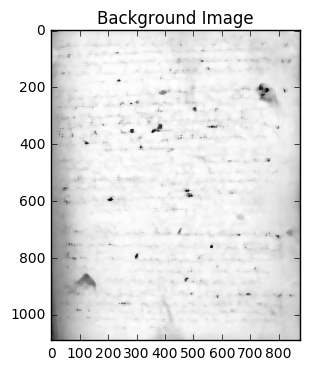

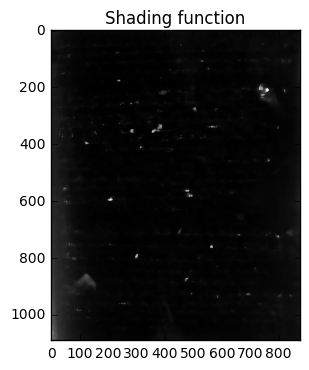

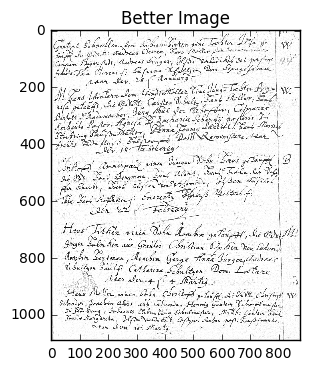

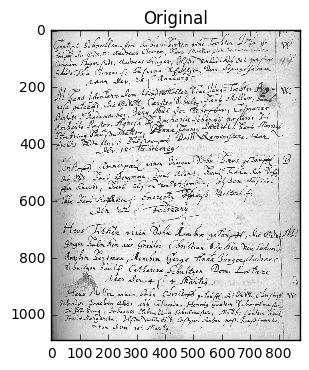

In [2]:
import numpy as np
from skimage.filters import rank
from scipy.interpolate import interp1d
img = misc.imread('schrift.png', mode = 'L') # 'schrift.png' or 'pebbles.jpg'
selem = np.ones((15,15))

# Median filter.
ranked_img = rank.median(img, selem)
print(ranked_img[0:5][0:5])
shading_function = 1 / ranked_img
print(shading_function[0:5][0:5])
better_img = img * shading_function
print(better_img[0:5][0:5])
normalized_img = ((better_img - np.amin(better_img))*((255.0-0)/(np.amax(better_img)-np.amin(better_img))))

plt.title('Background Image')
plt.imshow(ranked_img)
plt.show()
plt.title('Shading function')
plt.imshow(shading_function)
plt.show()
plt.title('Better Image')
plt.imshow(better_img,vmax=1)
plt.show()
plt.title('Original')
plt.imshow(img)
plt.show()

## Assignment 2: Edge-based segmentation  [6 Points]




### a) Edge linking

Describe in your own words the idea of edge linking. What is the goal? Why does it not necessarily yield closed
edge contours?

### b) Zero crossings

Explain what zero crossings are. Why does the detection of zero crossings always lead to closed contours?

### c) Zero crossings (implementation)

Provide an implementation of the zero crossing procedure described in (CV-07 slide 71). To get sensible results you should smooth the image before applying the Laplacian filter, e.g. using the Laplacian of a Gaussian (you may use buildins for the filterings steps).

In [ ]:
import numpy as np
a = np.array([[1,-1,2,2,-1]])
# np.where(np.diff(np.arange(4)))
zero_crossings = np.where(np.diff(np.signbit(a)))[1]
print(zero_crossings)

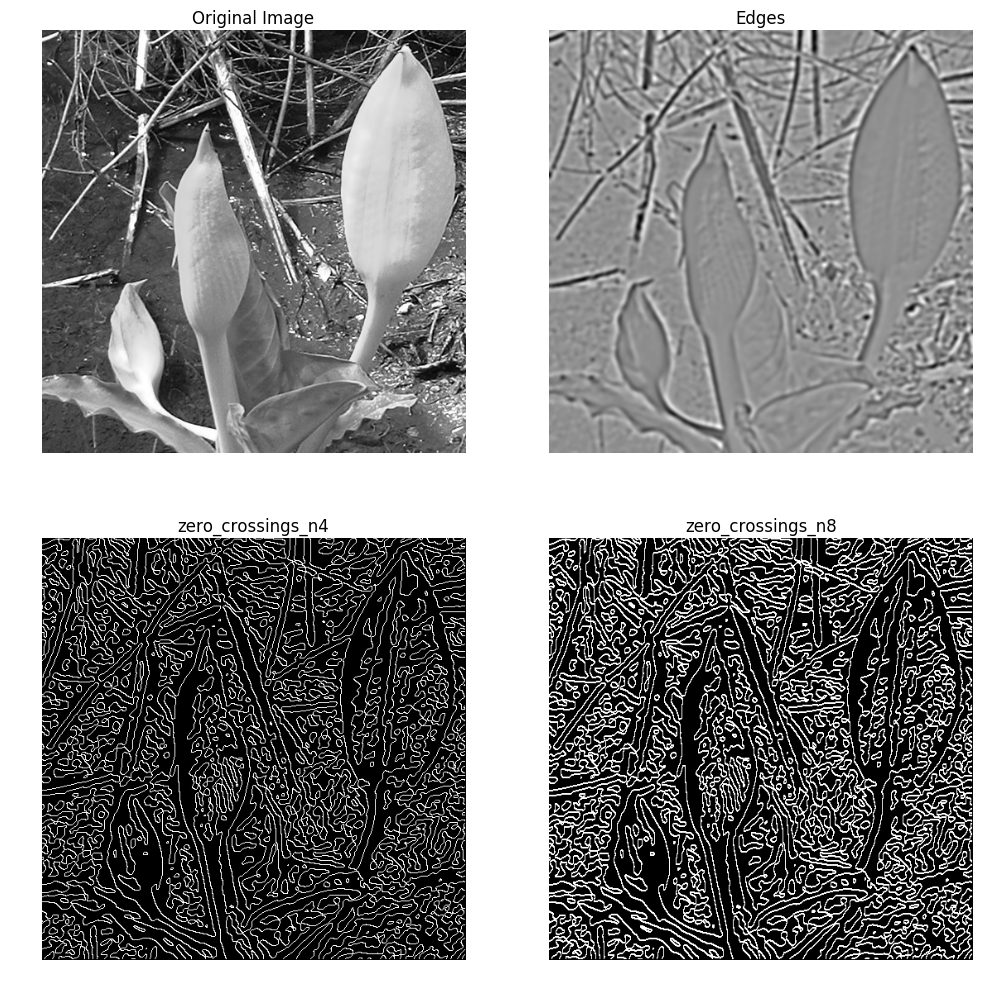

In [4]:
import numpy as np
from scipy import misc
from scipy.ndimage.filters import gaussian_laplace
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

img = misc.imread('swampflower.png', mode = 'F')

# Now compute edges and then zero crossings using the 4-neighborhood and the 8-neighborhood
edges = gaussian_laplace(img,sigma=3)
# sum(1 for i in range(0, len(a)-1) if a[i]*next((j for j in a[i+1:] if j != 0), 0) < 0)
zeros = np.zeros(edges.shape)
kernel = np.array([[0,0,0],[0,0,1]])
def zero_crossing(neighborhood=4):
    zero_crossings = zeros.copy()
    for rowIndex,row in enumerate(edges):
        for colIndex,pixel in enumerate(row):
                if rowIndex+ 1 < len(img) and colIndex +1 < len(row):
                    if np.sign(pixel) != np.sign(edges[rowIndex,colIndex+1]):
                        zero_crossings[rowIndex,colIndex] = 1
                    if np.sign(pixel) != np.sign(edges[rowIndex+1,colIndex]):
                        zero_crossings[rowIndex,colIndex] = 1
                if neighborhood == 8 and rowIndex+1 < len(img) and colIndex+1 < len(row):
                    if np.sign(pixel) != np.sign(edges[rowIndex+1,colIndex+1]):
                        zero_crossings[rowIndex,colIndex] = 1
                    if np.sign(pixel) != np.sign(edges[rowIndex-1,colIndex+1]):
                        zero_crossings[rowIndex,colIndex] = 1
    return zero_crossings

zero_crossings_n4 = zero_crossing(4)
zero_crossings_n8 = zero_crossing(8)

plt.figure(figsize=(12, 12))
plt.gray()

plt.subplot(2,2,1)
plt.axis('off')
plt.title('Original Image')
plt.imshow(img)

plt.subplot(2,2,2)
plt.axis('off')
plt.title('Edges')
plt.imshow(edges)

plt.subplot(2,2,3)
plt.axis('off')
plt.title('zero_crossings_n4')
plt.imshow(zero_crossings_n4)

plt.subplot(2,2,4)
plt.axis('off')
plt.title('zero_crossings_n8')
plt.imshow(zero_crossings_n8)

plt.show()

## Assignment 3: Watershed transform  [8 Points]



### a) Watershed transform

Explain in your own words the idea of watershed transform. How do the two different approaches from the lecture work? Why does watershed transform always give a closed contour?



### b) Implementation

Now implement the watershed transform using the flooding approach (CV-07 slide 76). Obviously, buildins for computing watershed transform are not allowed, but all other functions may be used.

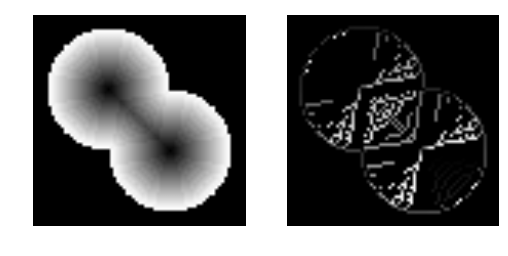

[[0 0 0]
 [0 2 2]
 [0 2 2]
 [0 2 2]
 [0 2 2]]


In [5]:
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt


def watershed(img, step = 1):
    """
    Perform watershed transform on a grayscale image.
    
    Args:
        img          the grayscale image
        
    Returns:
        A binary image containing the watersheds.
    """

    NO_LABEL = 0
    WATERSHED = NO_LABEL + 1
    NEW_LABEL = NO_LABEL + 2
    h=0

    # Gradient image.
    gradient =  np.gradient(img)[0] + np.gradient(img)[1]
    
    # Initialize labels as "no label".
    label = np.zeros(img.shape, np.uint16)
    kernel = np.array([[1,1,1],[1,0,1],[1,1,1]])
    labelCounter = 3
    maxGradient = np.amax(gradient)
    while h < maxGradient:
        for rowIndex,row in enumerate(gradient):
            for colIndex,pixel in enumerate(row):
                # Exclude boundary pixels.
#                 label[0,:] = 2
#                 label[:,0] = 2
#                 label[len(gradient)-1,:] =2
#                 label[:,len(row)-1] =2
                if rowIndex > 0 and rowIndex+1 < len(gradient) and colIndex > 0 and colIndex+1 < len(row):                    
                    if h >= pixel and label[rowIndex,colIndex] == 0:                    
#                         labels = [label[rowIndex-1,colIndex],label[rowIndex-1,colIndex-1],label[rowIndex-1,colIndex+1],label[rowIndex,colIndex+1],label[rowIndex+1,colIndex+1],label[rowIndex+1,colIndex],label[rowIndex+1,colIndex-1],label[rowIndex,colIndex-1]]
                        # Two-neighbor range.
                        labels = [label[rowIndex,colIndex+1],label[rowIndex+1,colIndex]]
#                         labels = gradient[rowIndex-1:rowIndex+1,colIndex-1:colIndex+1] * kernel[kernel==1]
                        
                        # First case - no neighbor pixels have labels.
                        if all(l == 0 for l in labels):
                            # Create first label in region.
                            label[rowIndex,colIndex] = NEW_LABEL
                        # Second case - one non-zero label in neighborhood.
                        elif len(set([i for i in labels if i > 0])) == 1:
                            # Assign non-zero label of neighbor(s).
                            label[rowIndex,colIndex] = labelCounter
                            labelCounter +=1
                        # Third case - multiple non-zero labels in neighborhood.
                        elif len(set([i for i in labels if i > 0])) > 1:
                            # Watershed.
                            label[rowIndex,colIndex] = WATERSHED
        h += step
                            
    return label

img = misc.imread('dist_circles.png', mode = 'L')

# print(np.gradient(img))
plt.gray()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img)

plt.subplot(1,2,2)
plt.axis('off')
water = watershed(img)
plt.imshow(water)
plt.show()
print(water[0:5,0:3])

In [6]:
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
img = misc.imread('dist_circles.png', mode = 'L')
gradient = abs(np.gradient(img)[0]+np.gradient(img)[1])
a = np.array([[0,1,2],[1,2,3],[2,3,4]])
# b = [0,1,2,3]
# new = [i for i in b if i > 1]
print(new[0])
# new = [0, 0, 0, 0, 0, 0, 0, 0]
# print(all(v == 0 for v in new))
print(np.gradient(a))
plt.imshow(np.gradient(a)[0],vmin=0,vmax=1)
plt.show()

NameError: name 'new' is not defined

### c) Application: maze

You can use watershed transform to find your way through a maze. To do so, first apply a distance transform to the maze and the flood the result. The watershed will show you the way through the maze. Explain why this works.

In [ ]:
from scipy import misc
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import distance_transform_edt

img = misc.imread('maze2.png', mode = 'L') # 'maze1.png' or 'maze2.png'

result = img[:,:,np.newaxis].repeat(3, 2)
plt.imshow(result)
plt.show()
dte = distance_transform_edt(img)
plt.imshow(dte)
plt.show()
wshed = watershed(dte)
plt.imshow(wshed)
plt.show()
print(wshed[0:2])
result[wshed,1:3] = 0

plt.figure(figsize=(10, 10))
plt.title('Solution')
plt.axis('off')
plt.gray()
plt.imshow(result)
plt.show()
